- `conda activate mri`
  - (created in `0_setup.ipynb`)

---

- `jupyter lab` => open this file

---

- Selected Jupyter default kernel (`ipykernel`)

---

---

# Use MATLAB to Create Blur/Contrast Variants

---

Following methods from:  

```
Soltani A, Nasri S. Improved algorithm for multiple sclerosis diagnosis in MRI using convolutional neural network. IET Image Processing. 2020;14(17):4507-4512. doi:https://doi.org/10.1049/iet-ipr.2019.0366
```

---

# Write MATLAB Functions

In [1]:
import os

# make MATLAB function directory
matlab_func_dir = os.path.expanduser('~/dissertation/data/MRI/matlab_functions')
os.makedirs(matlab_func_dir, exist_ok=True)

### `applyGaussian.m`

In [2]:
ml_func_path = os.path.join(matlab_func_dir, 'applyGaussian.m')

matlab_func="""
function applyGaussian(inputFile, outputFile, sigma)
    % applyGaussian applies a Gaussian blur to an image.
    %
    %   inputFile  : full path to the input image (assumed grayscale)
    %   outputFile : full path where the output image should be saved
    %   sigma      : standard deviation of the Gaussian kernel
    
    % Read the image.
    img = imread(inputFile);

    % In case the image is RGB, convert it to grayscale.
    if size(img,3) > 1
        img = rgb2gray(img);
    end
        
    % Apply the Gaussian filter.
    blurred = imgaussfilt(img, sigma);
    
    % Write the output image.
    imwrite(blurred, outputFile);
end
"""

with open(ml_func_path, 'w') as f:
    f.write(matlab_func)

### `applyImadjust.m`

In [3]:
ml_func_path = os.path.join(matlab_func_dir, 'applyImadjust.m')

matlab_func="""
function applyImadjust(inputFile, outputFile)
    % applyImadjust adjusts the intensity values of an image using imadjust.
    %
    %   inputFile  : full path to the input image (assumed grayscale)
    %   outputFile : full path where the output image should be saved

    % Read the image.
    img = imread(inputFile);

    % If the image is RGB, convert it to grayscale.
    if size(img,3) > 1
        img = rgb2gray(img);
    end

    % Adjust the image intensity values.
    adjusted = imadjust(img);

    % Write the output image.
    imwrite(adjusted, outputFile);
end
"""

with open(ml_func_path, 'w') as f:
    f.write(matlab_func)

### `applyHisteq.m`

In [4]:
ml_func_path = os.path.join(matlab_func_dir, 'applyHisteq.m')

matlab_func="""
function applyHisteq(inputFile, outputFile)
    % applyHisteq applies histogram equalization to an image.
    %
    %   inputFile  : full path to the input image (assumed grayscale)
    %   outputFile : full path where the output image should be saved

    % Read the image.
    img = imread(inputFile);

    % If the image is RGB, convert it to grayscale.
    if size(img,3) > 1
        img = rgb2gray(img);
    end

    % Apply histogram equalization.
    equalized = histeq(img);

    % Write the output image.
    imwrite(equalized, outputFile);
end
"""

with open(ml_func_path, 'w') as f:
    f.write(matlab_func)

### `applyAdapthisteq.m`

In [5]:
ml_func_path = os.path.join(matlab_func_dir, 'applyAdapthisteq.m')

matlab_func="""
function applyAdapthisteq(inputFile, outputFile)
    % applyAdapthisteq applies adaptive histogram equalization to an image.
    %
    %   inputFile  : full path to the input image (assumed grayscale)
    %   outputFile : full path where the output image should be saved

    % Read the image.
    img = imread(inputFile);

    % If the image is RGB, convert it to grayscale.
    if size(img,3) > 1
        img = rgb2gray(img);
    end

    % Apply adaptive histogram equalization.
    adjusted = adapthisteq(img);

    % Write the output image.
    imwrite(adjusted, outputFile);
end
"""

with open(ml_func_path, 'w') as f:
    f.write(matlab_func)

---

# Write Python Script to Execute MATLAB


In [7]:
script = """
import os
import glob
import matlab.engine

# Start MATLAB engine once.
print("Starting MATLAB engine...")
eng = matlab.engine.start_matlab()

# Add the directory containing MATLAB functions to the MATLAB path.
functions_dir = os.path.expanduser('~/dissertation/data/MRI/matlab_functions')
eng.addpath(functions_dir, nargout=0)

# Expand the root directory.
orig_root = os.path.expanduser('~/dissertation/data/MRI/')

# Get list of all matching directories.
matching_dirs = [
    d for d in glob.glob(os.path.join(orig_root, '_[MH]*/*'), recursive=True)
    if os.path.isdir(d)
]

# Filter folders by matching substrings.
slice_folders_ms_isbi_ph3_test =    [x for x in matching_dirs if '_MS__ISBI_3T_test' in x]
slice_folders_ms_isbi_ph3_train =   [x for x in matching_dirs if '_MS__ISBI_3T_train' in x]
slice_folders_ms_muslim_15t       = [x for x in matching_dirs if '_MS__Muslim_et_al_15T' in x]
slice_folders_healthy_ph3         = [x for x in matching_dirs if '_Healthy__IXI_3T' in x]
slice_folders_healthy_ph15        = [x for x in matching_dirs if '_Healthy__IXI_15T_Guys' in x]
slice_folders_healthy_ge15        = [x for x in matching_dirs if '_Healthy__IXI_15T_IOP' in x]

# Combine all folder lists.
all_folders = (
    slice_folders_ms_isbi_ph3_test +
    slice_folders_ms_isbi_ph3_train +
    slice_folders_ms_muslim_15t +
    slice_folders_healthy_ph3 +
    slice_folders_healthy_ph15 +
    slice_folders_healthy_ge15
)

# Define sigma values for blur.
sigma_values = [1, 2, 3, 4]

# Define the contrast operations as tuples:
# (readable name, MATLAB function name, destination folder suffix)
contrast_operations = [
    ('imadjust', 'applyImadjust', '_contrast_imadjust'),
    ('histeq', 'applyHisteq', '_contrast_histeq'),
    ('adapthisteq', 'applyAdapthisteq', '_contrast_adapthisteq')
]

# Loop over each folder and process all PNG files.
for folder in all_folders:
    png_files = glob.glob(os.path.join(folder, '*.png'))
    for png_file in png_files:
        # --- Blur Operations ---
        for sigma in sigma_values:
            # Compute the relative path.
            relative_path = os.path.relpath(folder, orig_root)
            # Destination root includes the sigma value.
            dest_root = os.path.join(orig_root, f'_blurred_SD{sigma}')
            # Destination folder mirrors the original folder structure.
            dest_folder = os.path.join(dest_root, relative_path)
            os.makedirs(dest_folder, exist_ok=True)
            
            # The output filename is the same as the input filename.
            filename = os.path.basename(png_file)
            dest_file = os.path.join(dest_folder, filename)
            
            print(f"Blurring {png_file.split('/data/')[1]} with sigma={sigma}")
            print(f"Saving to {dest_file.split('/data/')[1]}")
            
            # Call the MATLAB blur function.
            eng.applyGaussian(png_file, dest_file, sigma, nargout=0)
        
        # --- Contrast Operations ---
        for op_name, matlab_func, folder_suffix in contrast_operations:
            # Compute the relative path.
            relative_path = os.path.relpath(folder, orig_root)
            dest_root = os.path.join(orig_root, folder_suffix)
            dest_folder = os.path.join(dest_root, relative_path)
            os.makedirs(dest_folder, exist_ok=True)
            
            filename = os.path.basename(png_file)
            dest_file = os.path.join(dest_folder, filename)
            
            print(f"Applying {op_name} on {png_file.split('/data/')[1]}")
            print(f"Saving to {dest_file.split('/data/')[1]}")
            
            # Dynamically get the function from the MATLAB engine and call it.
            func = getattr(eng, matlab_func)
            func(png_file, dest_file, nargout=0)
            

# When finished, quit MATLAB.
print("Processing complete. Quitting MATLAB engine.")
eng.quit()
"""

with open('8__matlab_execute.py', 'w') as f:
    f.write(script)

# Execute Script

On command line:

- `conda activate mri`
- `source matlab_env/bin/activate`
  - (created in `0_setup.ipynb`)
- `module load matlab/R2023b`
- `python 8__matlab_execute.py`

---

---

---

---

# Create Figures

---

## Contrast and Blur Figures

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import numpy as np
import string

# Set publication quality parameters
rcParams['font.family'] = 'sans-serif'
rcParams['font.size'] = 10
rcParams['axes.labelsize'] = 10
rcParams['axes.titlesize'] = 11
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['figure.dpi'] = 300

nb_name = '8__matlab_blur_and_contrast'

def create_contrast_and_blur_figures(slc='100'):
    
    # Figure 1: Contrast variations
    fig1, axes1 = plt.subplots(1, 4, figsize=(8, 4))
    fig1.subplots_adjust(wspace=0.05, hspace=0.05, left=0.02, right=0.98, top=0.95, bottom=0.05)
    
    # Define image paths for contrast figure
    contrast_paths = [
        f'./_MS__ISBI_3T_train/01_01/slice_{slc}.png',
        f'./_contrast_adapthisteq/_MS__ISBI_3T_train/01_01/slice_{slc}.png',
        f'./_contrast_histeq/_MS__ISBI_3T_train/01_01/slice_{slc}.png',
        f'./_contrast_imadjust/_MS__ISBI_3T_train/01_01/slice_{slc}.png'
    ]
    
    contrast_titles = ['Original', 'CLAHE', 'Histogram Eq.', 'Intensity Adj.']
    
    # Load and display contrast images
    for idx, (ax, path, title) in enumerate(zip(axes1.flat, contrast_paths, contrast_titles)):
        try:
            img = mpimg.imread(path)
            # Rotate 90 degrees counter-clockwise
            import numpy as np
            img_rotated = np.rot90(img, k=1)  # k=1 for 90 degrees CCW
            ax.imshow(img_rotated, cmap='gray' if len(img_rotated.shape) == 2 else None)
        except FileNotFoundError:
            # Create placeholder if image not found
            ax.text(0.5, 0.5, 'Image not found', ha='center', va='center', transform=ax.transAxes)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
        
        # Add subplot label (a, b, c, d)
        ax.text(0.05, 0.95, f'({string.ascii_lowercase[idx]})', transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top', ha='left', color='white',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
        
        # Add title
        ax.set_title(title, fontsize=10, pad=5)
        
        # Remove axes
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    plt.suptitle('Figure 1: Contrast Enhancement Methods', fontsize=12, y=0.9)
    plt.tight_layout()
    
    # Save Figure 1
    fig1.savefig(f'{nb_name}__figure1_contrast_variations__slice{slc}.png', dpi=300, 
                 bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    
    # Print Figure 1 legend
    print("\n" + "="*80)
    print("FIGURE 1 LEGEND")
    print("="*80)
    print("Figure 1. Comparison of contrast enhancement methods applied to brain MRI slice.")
    print("(a) Original T2-weighted MRI image showing baseline contrast.")
    print("(b) Contrast Limited Adaptive Histogram Equalization (CLAHE) applied with")
    print("    adaptive local contrast enhancement.")
    print("(c) Global histogram equalization applied for uniform intensity distribution.")
    print("(d) Intensity adjustment using linear contrast stretching with saturation")
    print("    limits at 1% and 99% of the intensity range.")
    print("="*80 + "\n")
    
    # Figure 2: Blur variations
    fig2, axes2 = plt.subplots(1, 5, figsize=(10, 5))
    fig2.subplots_adjust(wspace=0.05, hspace=0.05, left=0.02, right=0.98, top=0.95, bottom=0.05)
    
    # Define image paths for blur figure
    blur_paths = [
        f'./_MS__ISBI_3T_train/01_01/slice_{slc}.png',
        f'./_blurred_SD1/_MS__ISBI_3T_train/01_01/slice_{slc}.png',
        f'./_blurred_SD2/_MS__ISBI_3T_train/01_01/slice_{slc}.png',
        f'./_blurred_SD3/_MS__ISBI_3T_train/01_01/slice_{slc}.png',
        f'./_blurred_SD4/_MS__ISBI_3T_train/01_01/slice_{slc}.png'
    ]
    
    blur_titles = ['Original', 'σ = 1', 'σ = 2', 'σ = 3', 'σ = 4']
    
    # Load and display blur images
    for idx, (ax, path, title) in enumerate(zip(axes2.flat, blur_paths, blur_titles)):
        try:
            img = mpimg.imread(path)
            # Rotate 90 degrees counter-clockwise
            img_rotated = np.rot90(img, k=1)  # k=1 for 90 degrees CCW
            ax.imshow(img_rotated, cmap='gray' if len(img_rotated.shape) == 2 else None)
        except FileNotFoundError:
            # Create placeholder if image not found
            ax.text(0.5, 0.5, 'Image not found', ha='center', va='center', transform=ax.transAxes)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
        
        # Add subplot label (a, b, c, d, e)
        ax.text(0.05, 0.95, f'({string.ascii_lowercase[idx]})', transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top', ha='left', color='white',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
        
        # Add title
        ax.set_title(title, fontsize=10, pad=5)
        
        # Remove axes
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    plt.suptitle('Figure 2: Gaussian Blur with Varying Standard Deviations', fontsize=12, y=0.85)
    plt.tight_layout()
    
    # Save Figure 2
    fig2.savefig(f'{nb_name}__figure2_blur_variations__slice{slc}', dpi=300, 
                 bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    
    # Print Figure 2 legend
    print("\n" + "="*80)
    print("FIGURE 2 LEGEND")
    print("="*80)
    print("Figure 2. Effect of Gaussian blur with increasing standard deviations on")
    print("brain MRI image quality.")
    print("(a) Original T2-weighted MRI image with preserved edge definition and detail.")
    print("(b) Gaussian blur applied with standard deviation σ = 1 pixel, showing")
    print("    minimal smoothing while preserving most structural details.")
    print("(c) Gaussian blur with σ = 2 pixels, demonstrating moderate smoothing with")
    print("    some loss of fine anatomical features.")
    print("(d) Gaussian blur with σ = 3 pixels, showing significant smoothing and")
    print("    reduced edge sharpness in cortical regions.")
    print("(e) Gaussian blur with σ = 4 pixels, exhibiting substantial detail loss")
    print("    and marked degradation of tissue boundaries.")
    print("="*80 + "\n")

---

---

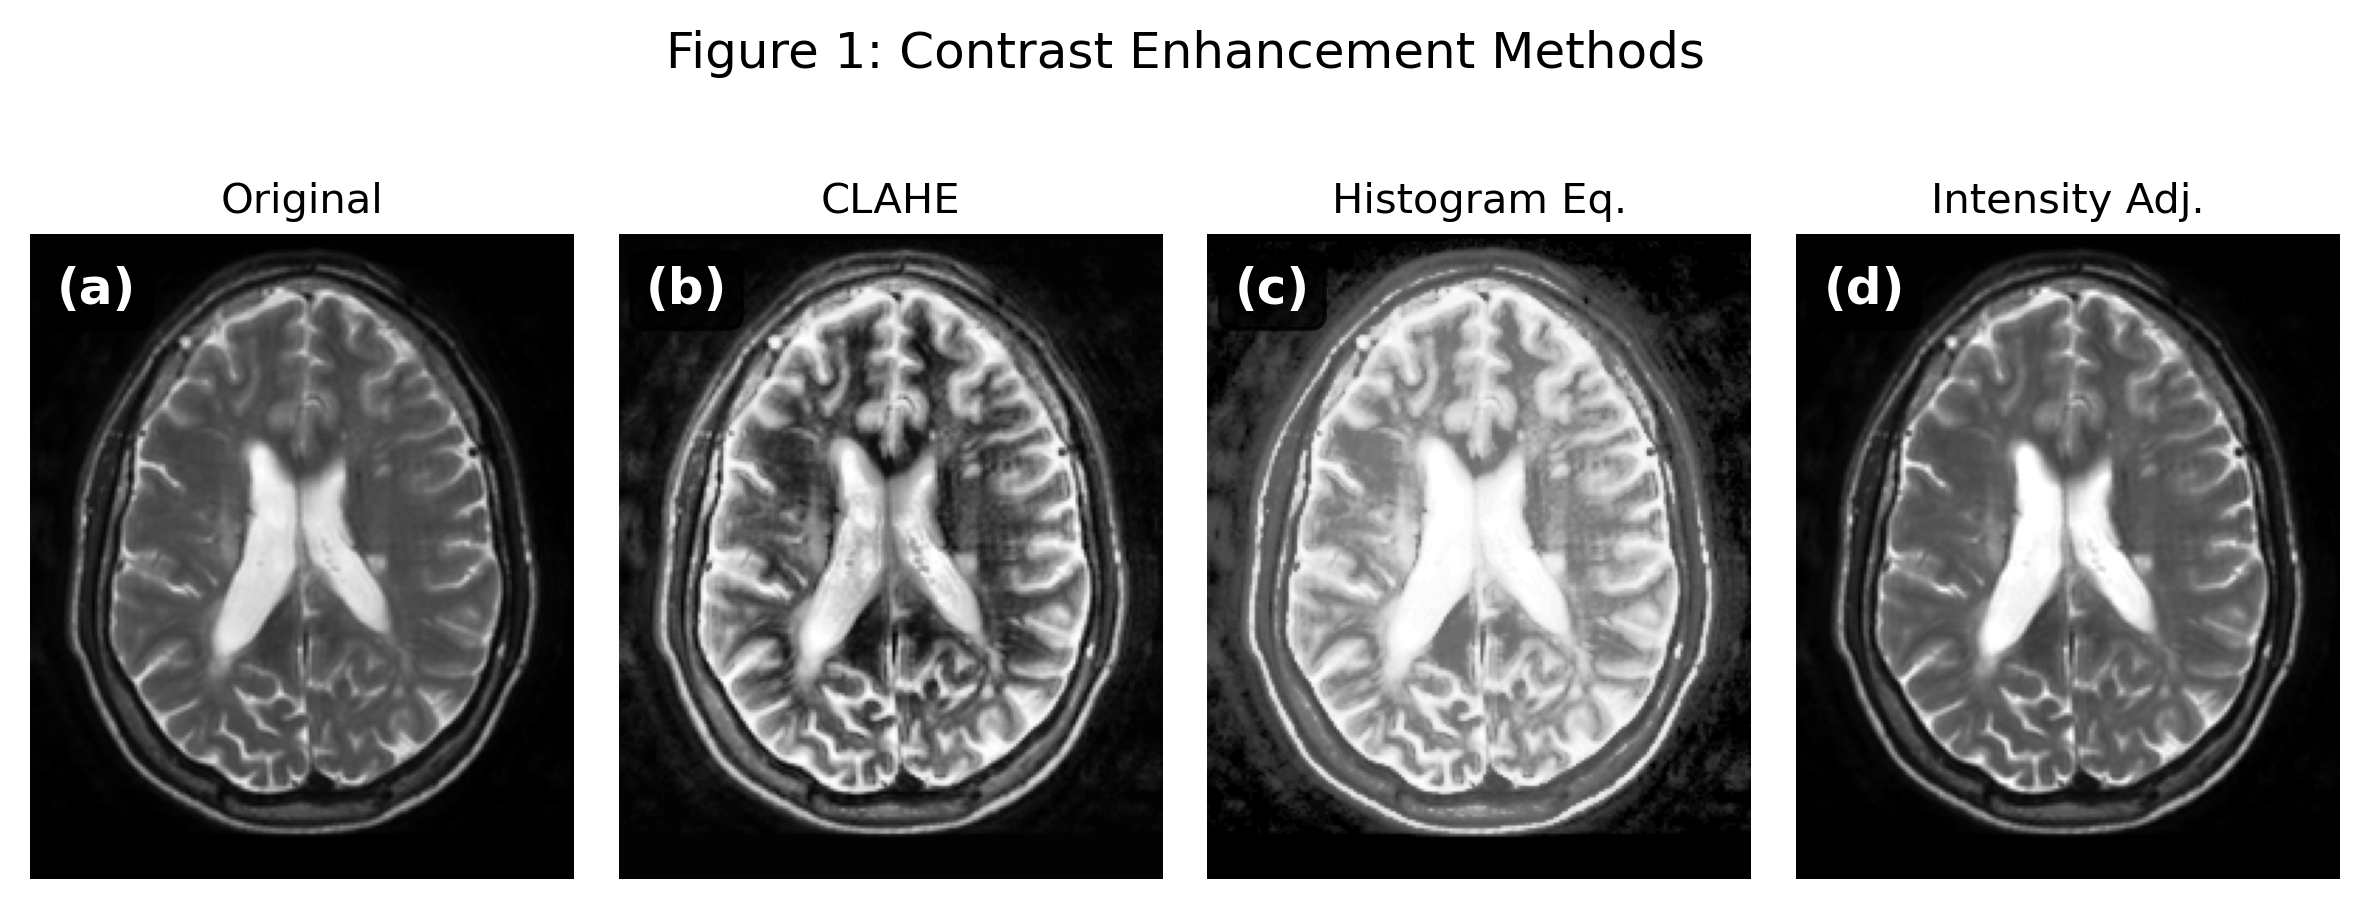


FIGURE 1 LEGEND
Figure 1. Comparison of contrast enhancement methods applied to brain MRI slice.
(a) Original T2-weighted MRI image showing baseline contrast.
(b) Contrast Limited Adaptive Histogram Equalization (CLAHE) applied with
    adaptive local contrast enhancement.
(c) Global histogram equalization applied for uniform intensity distribution.
(d) Intensity adjustment using linear contrast stretching with saturation
    limits at 1% and 99% of the intensity range.



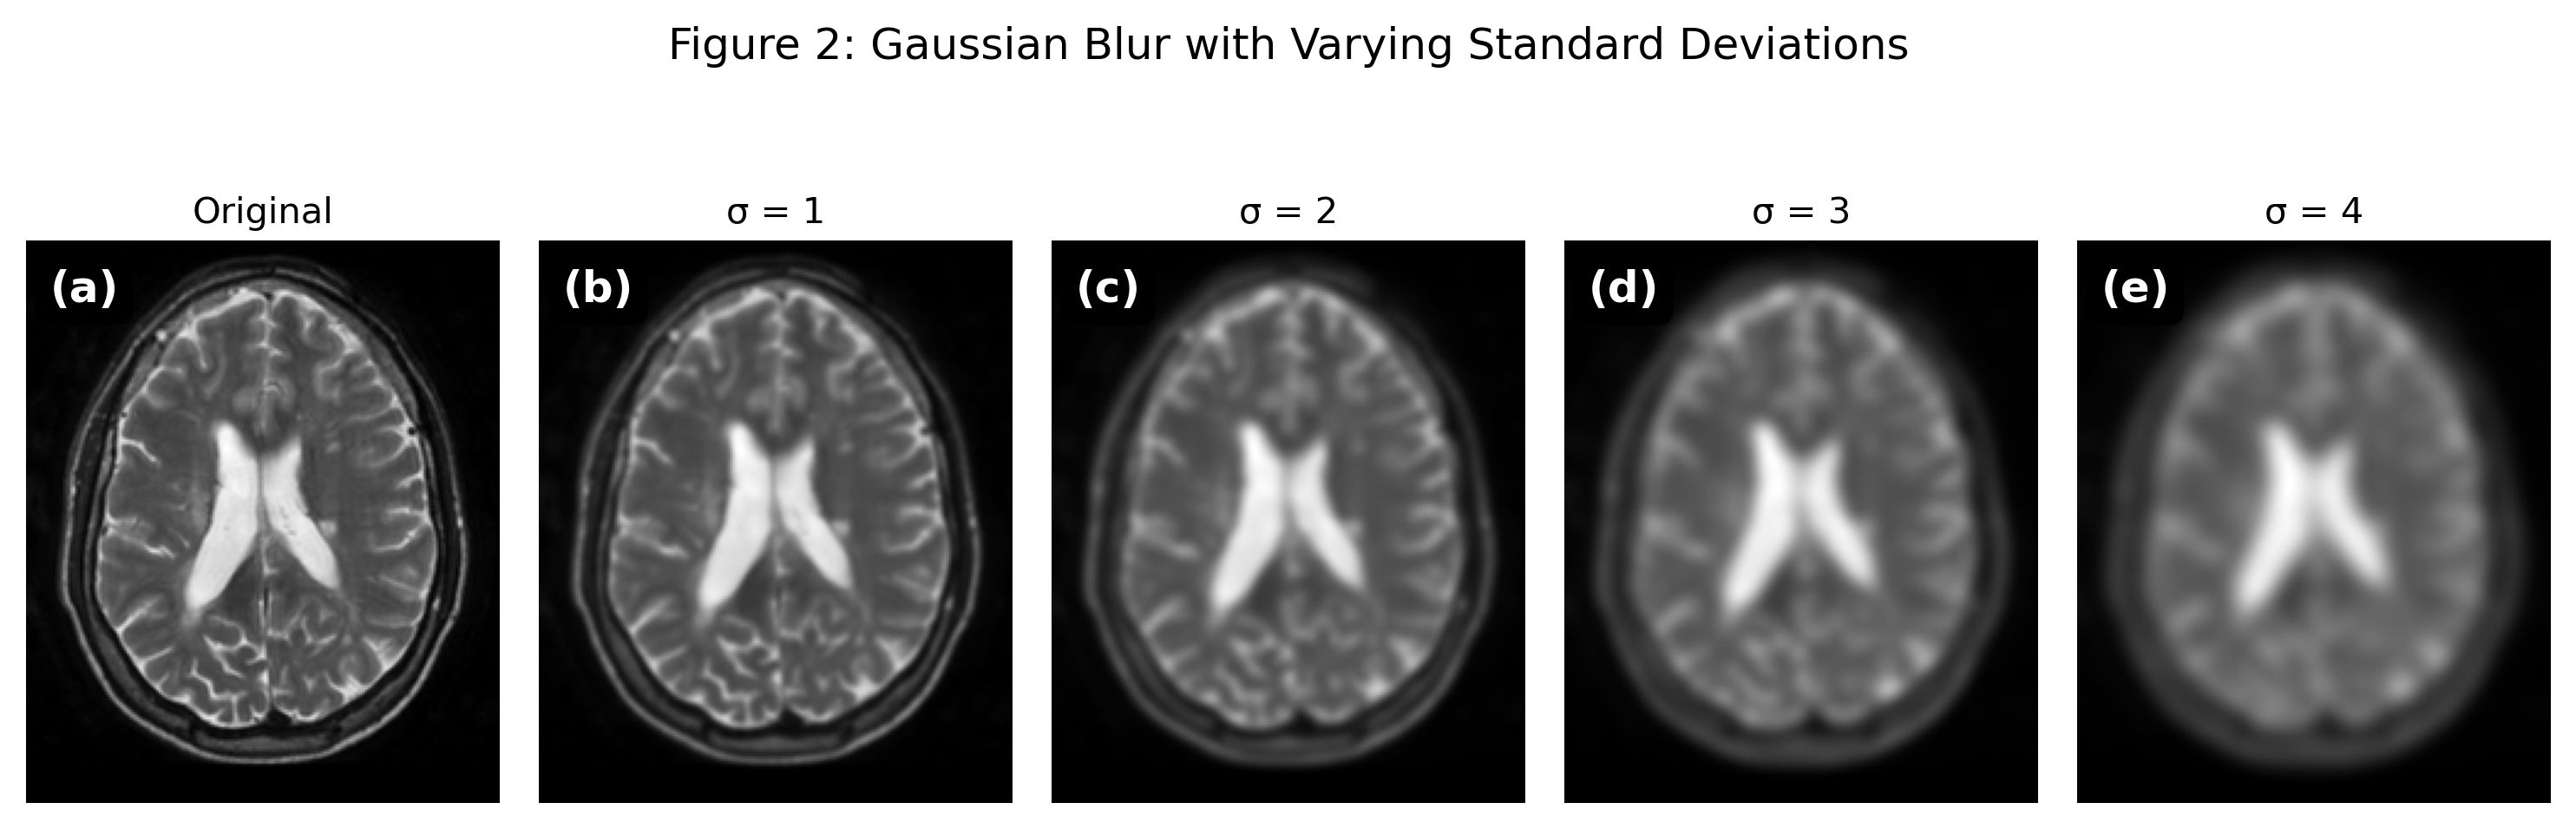


FIGURE 2 LEGEND
Figure 2. Effect of Gaussian blur with increasing standard deviations on
brain MRI image quality.
(a) Original T2-weighted MRI image with preserved edge definition and detail.
(b) Gaussian blur applied with standard deviation σ = 1 pixel, showing
    minimal smoothing while preserving most structural details.
(c) Gaussian blur with σ = 2 pixels, demonstrating moderate smoothing with
    some loss of fine anatomical features.
(d) Gaussian blur with σ = 3 pixels, showing significant smoothing and
    reduced edge sharpness in cortical regions.
(e) Gaussian blur with σ = 4 pixels, exhibiting substantial detail loss
    and marked degradation of tissue boundaries.



In [ ]:
create_contrast_and_blur_figures(slc='100')

---

---

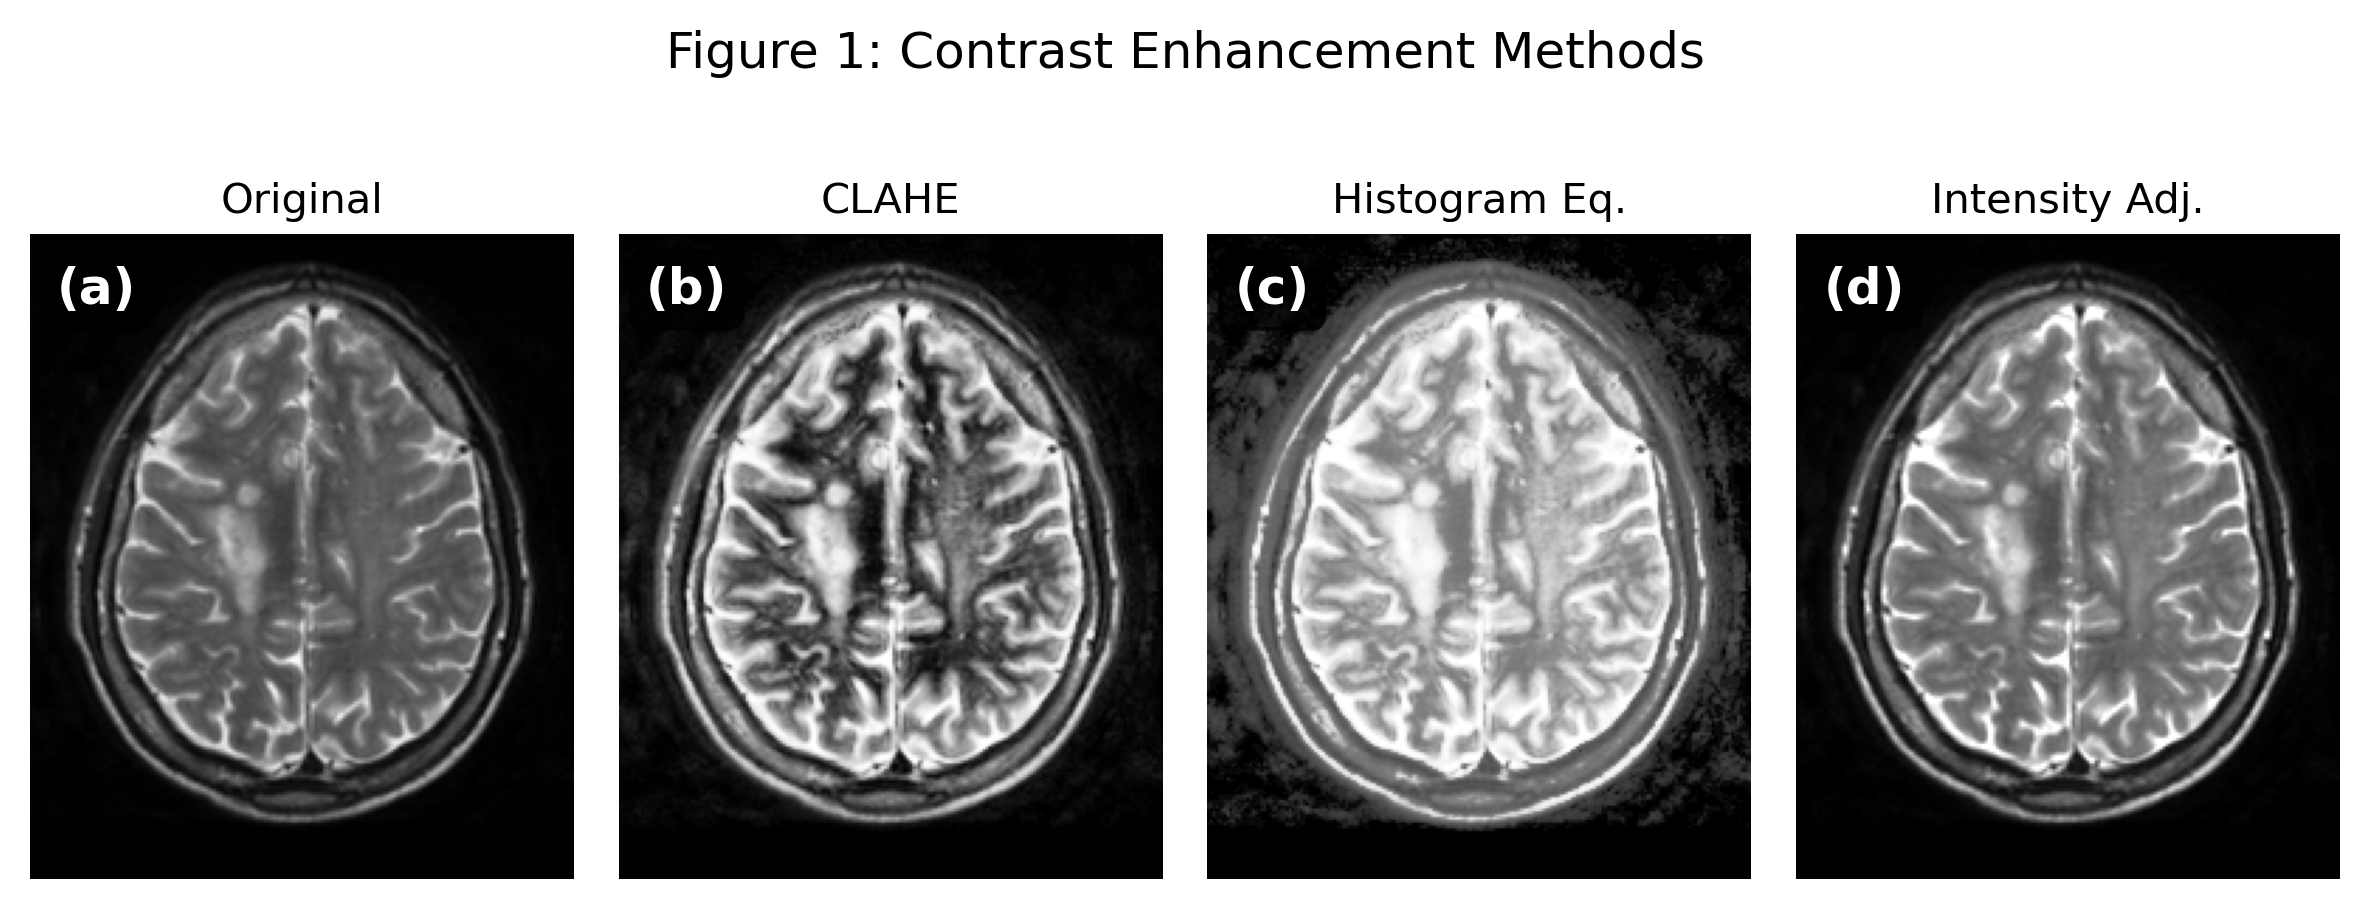


FIGURE 1 LEGEND
Figure 1. Comparison of contrast enhancement methods applied to brain MRI slice.
(a) Original T2-weighted MRI image showing baseline contrast.
(b) Contrast Limited Adaptive Histogram Equalization (CLAHE) applied with
    adaptive local contrast enhancement.
(c) Global histogram equalization applied for uniform intensity distribution.
(d) Intensity adjustment using linear contrast stretching with saturation
    limits at 1% and 99% of the intensity range.



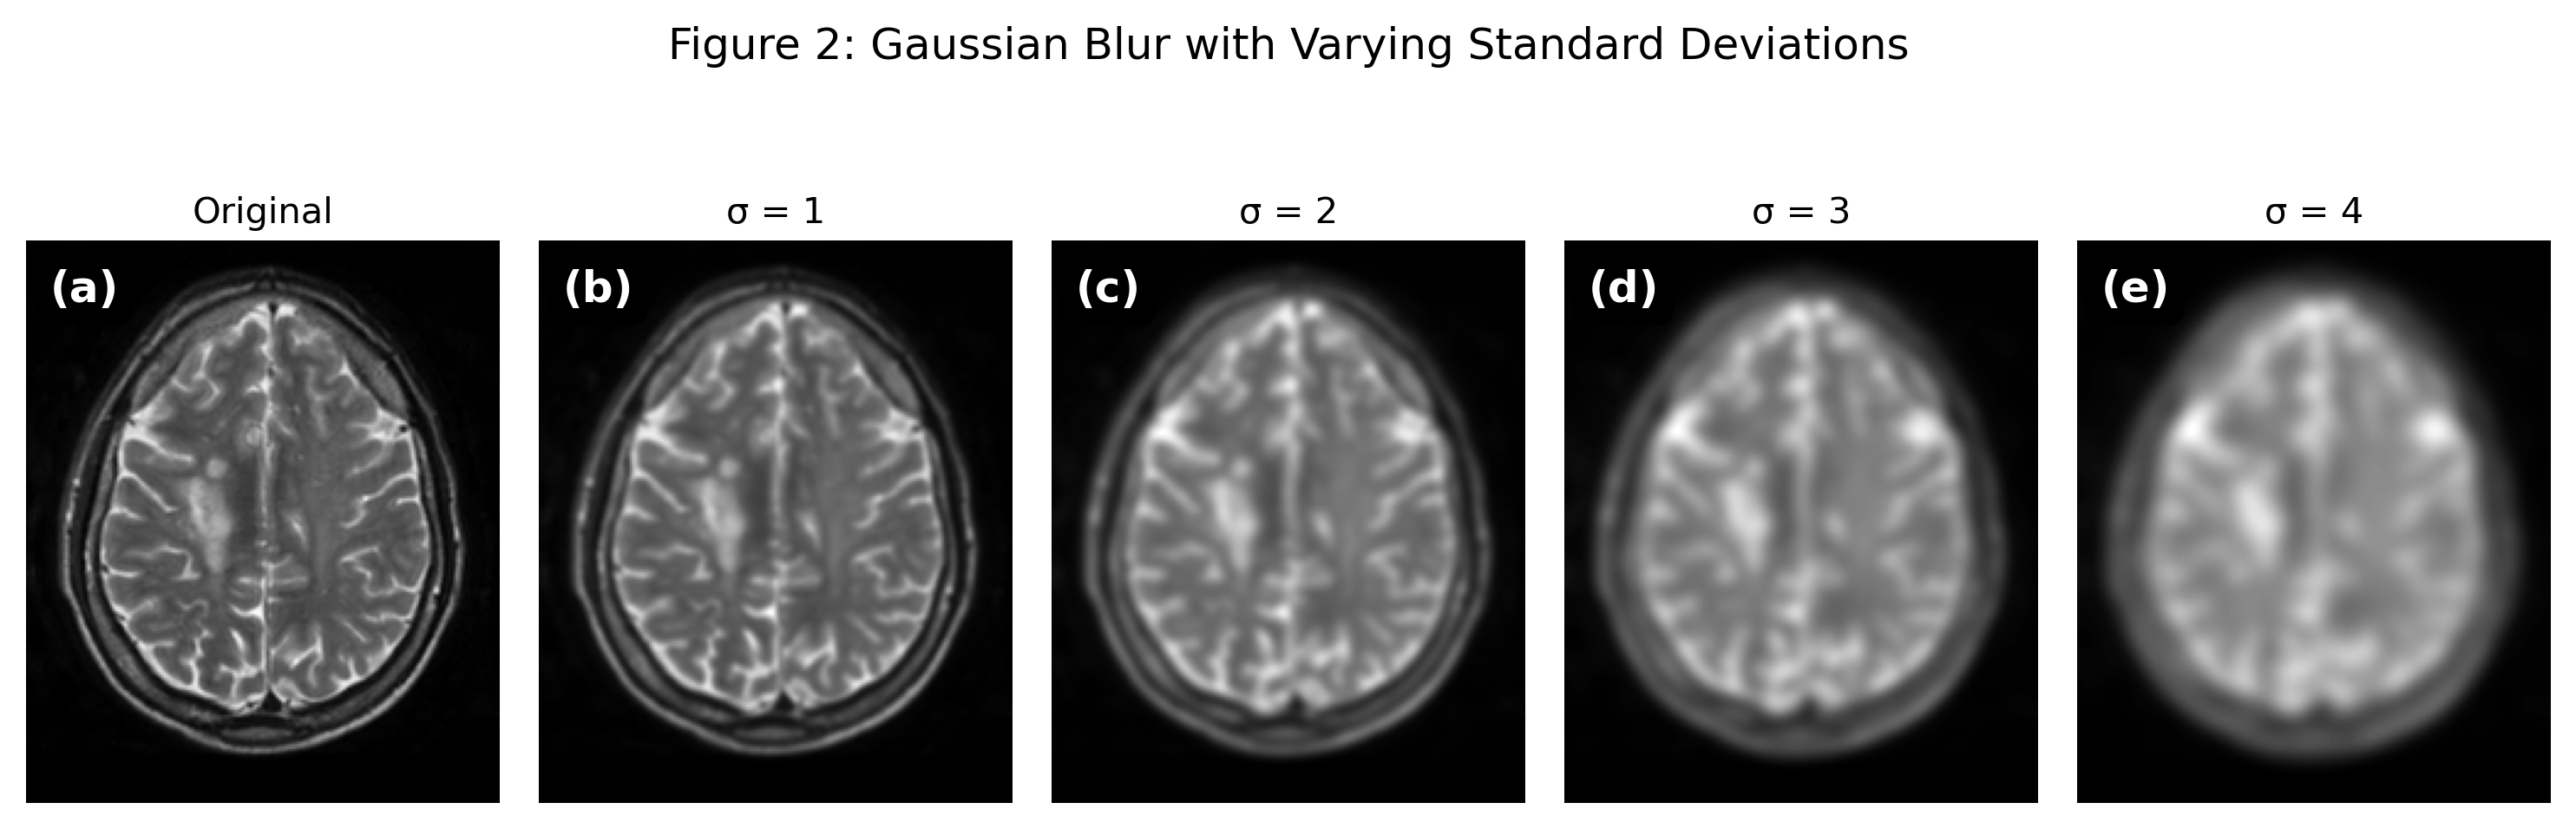


FIGURE 2 LEGEND
Figure 2. Effect of Gaussian blur with increasing standard deviations on
brain MRI image quality.
(a) Original T2-weighted MRI image with preserved edge definition and detail.
(b) Gaussian blur applied with standard deviation σ = 1 pixel, showing
    minimal smoothing while preserving most structural details.
(c) Gaussian blur with σ = 2 pixels, demonstrating moderate smoothing with
    some loss of fine anatomical features.
(d) Gaussian blur with σ = 3 pixels, showing significant smoothing and
    reduced edge sharpness in cortical regions.
(e) Gaussian blur with σ = 4 pixels, exhibiting substantial detail loss
    and marked degradation of tissue boundaries.



In [46]:
create_contrast_and_blur_figures(slc='111')

---

---

---

## Combined Contrast + Blur Figure

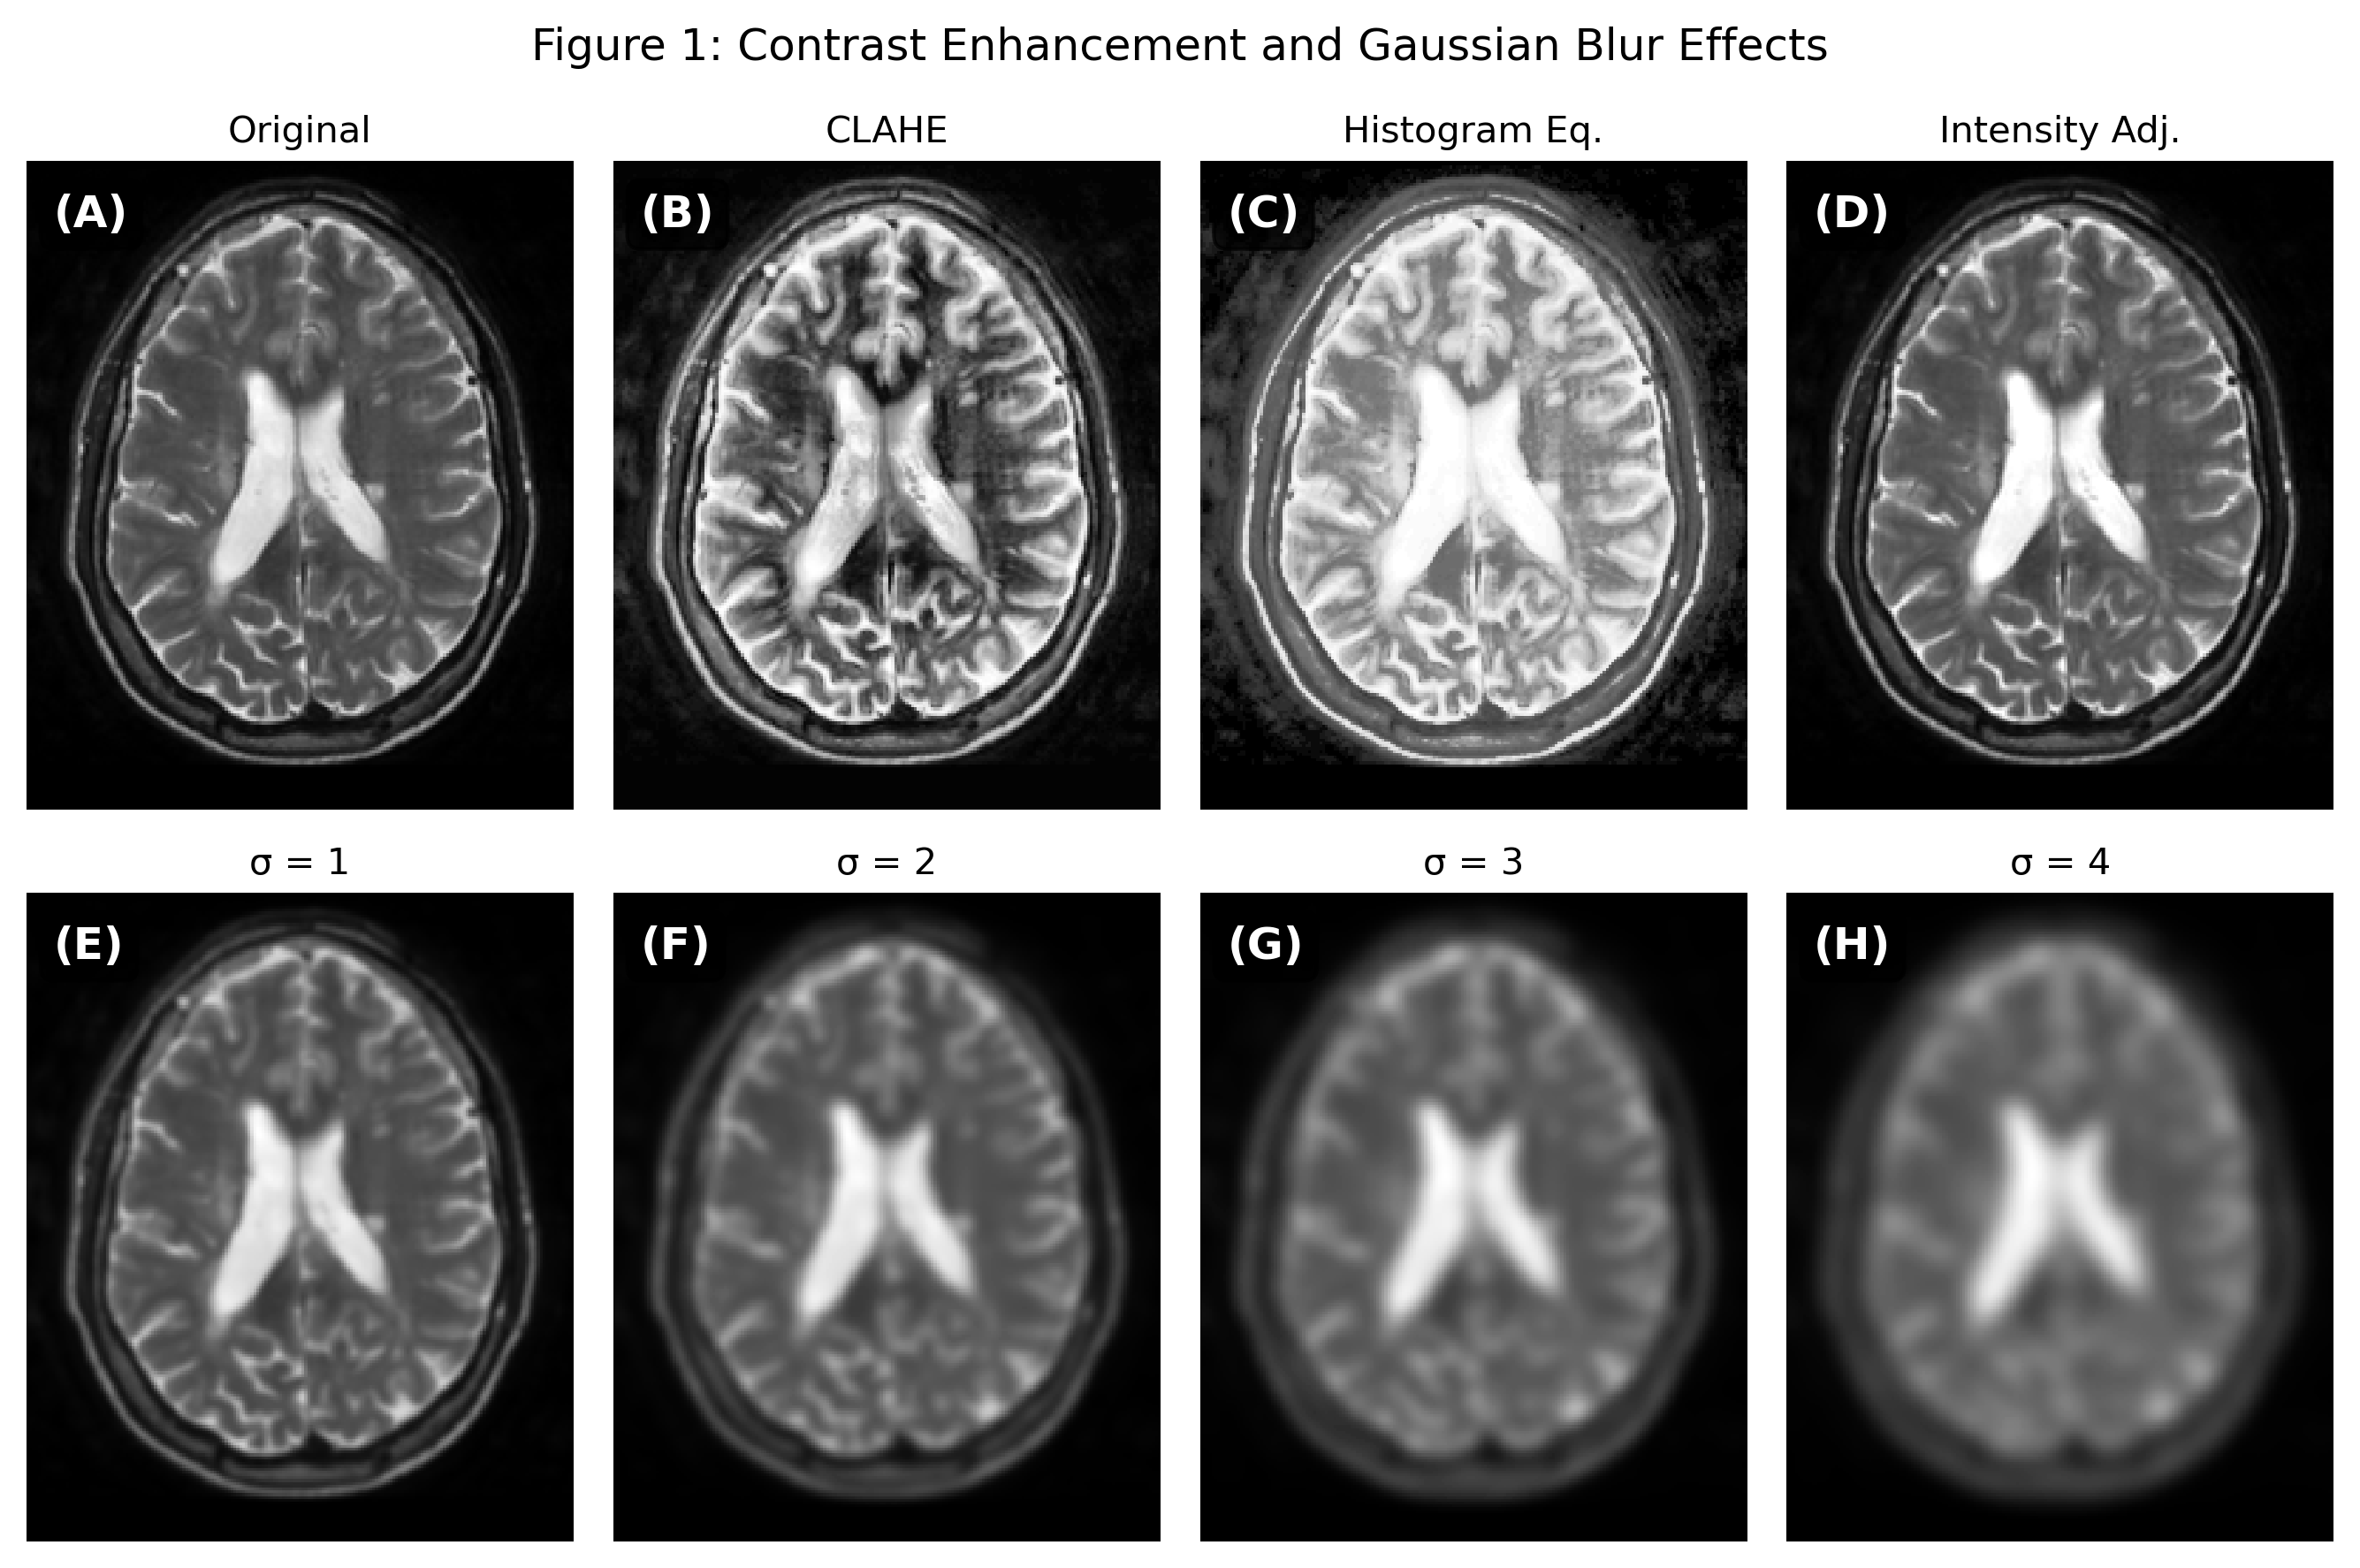


FIGURE LEGEND
Figure 1. Comparison of contrast enhancement methods and Gaussian blur effects
on brain MRI slice.

Top row - Contrast enhancement methods:
(A) Original T2-weighted MRI image showing baseline contrast and image quality.
(B) Contrast Limited Adaptive Histogram Equalization (CLAHE) applied with
    adaptive local contrast enhancement.
(C) Global histogram equalization applied for uniform intensity distribution.
(D) Intensity adjustment using linear contrast stretching with saturation
    limits at 1% and 99% of the intensity range.

Bottom row - Gaussian blur with increasing standard deviations:
(E) Gaussian blur applied with standard deviation σ = 1 pixel, showing
    minimal smoothing while preserving most structural details.
(F) Gaussian blur with σ = 2 pixels, demonstrating moderate smoothing with
    some loss of fine anatomical features.
(G) Gaussian blur with σ = 3 pixels, showing significant smoothing and
    reduced edge sharpness in cortical regions.
(H) Gaussian

In [59]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import numpy as np
import string

# Set publication quality parameters
rcParams['font.family'] = 'sans-serif'
rcParams['font.size'] = 10
rcParams['axes.labelsize'] = 10
rcParams['axes.titlesize'] = 11
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['figure.dpi'] = 300

nb_name = '8__matlab_blur_and_contrast'

def create_combined_figure(slc='100'):
    
    # Create combined figure with 2 rows, 4 columns
    fig, axes = plt.subplots(2, 4, figsize=(9, 6))
    fig.subplots_adjust(wspace=0.05, hspace=0.15, left=0.02, right=0.98, top=0.95, bottom=0.05)
    
    # Define image paths for contrast row (top)
    contrast_paths = [
        f'./_MS__ISBI_3T_train/01_01/slice_{slc}.png',
        f'./_contrast_adapthisteq/_MS__ISBI_3T_train/01_01/slice_{slc}.png',
        f'./_contrast_histeq/_MS__ISBI_3T_train/01_01/slice_{slc}.png',
        f'./_contrast_imadjust/_MS__ISBI_3T_train/01_01/slice_{slc}.png'
    ]
    
    contrast_titles = ['Original', 'CLAHE', 'Histogram Eq.', 'Intensity Adj.']
    
    # Load and display contrast images (top row)
    for idx, (ax, path, title) in enumerate(zip(axes[0], contrast_paths, contrast_titles)):
        try:
            img = mpimg.imread(path)
            # Rotate 90 degrees counter-clockwise
            img_rotated = np.rot90(img, k=1)  # k=1 for 90 degrees CCW
            ax.imshow(img_rotated, cmap='gray' if len(img_rotated.shape) == 2 else None)
        except FileNotFoundError:
            # Create placeholder if image not found
            ax.text(0.5, 0.5, 'Image not found', ha='center', va='center', transform=ax.transAxes)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
        
        # Add subplot label (A, B, C, D)
        ax.text(0.05, 0.95, f'({string.ascii_uppercase[idx]})', transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top', ha='left', color='white',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
        
        # Add title
        ax.set_title(title, fontsize=10, pad=5)
        
        # Remove axes
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    # Define image paths for blur row (bottom) - no original since it's already shown as (A)
    blur_paths = [
        f'./_blurred_SD1/_MS__ISBI_3T_train/01_01/slice_{slc}.png',
        f'./_blurred_SD2/_MS__ISBI_3T_train/01_01/slice_{slc}.png',
        f'./_blurred_SD3/_MS__ISBI_3T_train/01_01/slice_{slc}.png',
        f'./_blurred_SD4/_MS__ISBI_3T_train/01_01/slice_{slc}.png'
    ]
    
    blur_titles = ['σ = 1', 'σ = 2', 'σ = 3', 'σ = 4']
    
    # Load and display blur images (bottom row)
    for idx, (ax, path, title) in enumerate(zip(axes[1], blur_paths, blur_titles)):
        try:
            img = mpimg.imread(path)
            # Rotate 90 degrees counter-clockwise
            img_rotated = np.rot90(img, k=1)  # k=1 for 90 degrees CCW
            ax.imshow(img_rotated, cmap='gray' if len(img_rotated.shape) == 2 else None)
        except FileNotFoundError:
            # Create placeholder if image not found
            ax.text(0.5, 0.5, 'Image not found', ha='center', va='center', transform=ax.transAxes)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
        
        # Add subplot label (E, F, G, H)
        ax.text(0.05, 0.95, f'({string.ascii_uppercase[idx + 4]})', transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top', ha='left', color='white',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
        
        # Add title
        ax.set_title(title, fontsize=10, pad=5)
        
        # Remove axes
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    plt.suptitle('Figure 1: Contrast Enhancement and Gaussian Blur Effects', fontsize=12, y=0.98)
    plt.tight_layout()
    
    # Save combined figure
    fig.savefig(f'{nb_name}__combined_contrast_blur__slice{slc}.png', dpi=300, 
                bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    
    # Print combined figure legend
    print("\n" + "="*80)
    print("FIGURE LEGEND")
    print("="*80)
    print("Figure 1. Comparison of contrast enhancement methods and Gaussian blur effects")
    print("on brain MRI slice.")
    print("")
    print("Top row - Contrast enhancement methods:")
    print("(A) Original T2-weighted MRI image showing baseline contrast and image quality.")
    print("(B) Contrast Limited Adaptive Histogram Equalization (CLAHE) applied with")
    print("    adaptive local contrast enhancement.")
    print("(C) Global histogram equalization applied for uniform intensity distribution.")
    print("(D) Intensity adjustment using linear contrast stretching with saturation")
    print("    limits at 1% and 99% of the intensity range.")
    print("")
    print("Bottom row - Gaussian blur with increasing standard deviations:")
    print("(E) Gaussian blur applied with standard deviation σ = 1 pixel, showing")
    print("    minimal smoothing while preserving most structural details.")
    print("(F) Gaussian blur with σ = 2 pixels, demonstrating moderate smoothing with")
    print("    some loss of fine anatomical features.")
    print("(G) Gaussian blur with σ = 3 pixels, showing significant smoothing and")
    print("    reduced edge sharpness in cortical regions.")
    print("(H) Gaussian blur with σ = 4 pixels, exhibiting substantial detail loss")
    print("    and marked degradation of tissue boundaries.")
    print("="*80 + "\n")

create_combined_figure('100')

---

---

---

---

---